# Tarea 1: Diseño Avanzado de Algoritmos
## Uber
### Daniel San Martín

In [485]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sp_dist
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
np.random.seed(666)

In [486]:
DIR = "data/"

In [487]:
# Manhattan distance
d  = lambda p1, p2: np.linalg.norm(p1 - p2, ord=1) # Compare two points
dv = lambda v1, v2: np.sum(np.abs(v1-v2), axis=1) #  Elementwise distance
dM = lambda v1, v2: sp_dist.cdist(v1, v2, metric='cityblock') # Distance matrix 

In [488]:
def loadRequest(request):
    data = []
    file = open(request)
    for line in file:
        data.append(list(map(int, line.strip().replace("-", " ").split())))
    file.close()
    return np.array(data)

In [489]:
def saveOutput(costs, filename):
    output = np.zeros((len(costs), 2), dtype=int)
    output[:,0] = np.arange(len(costs))
    output[:,1] = costs
    np.savetxt(filename, output, delimiter=" ", fmt='%i')

In [490]:
def plotPositions(manana, tarde, noche):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(16, 5))
    ax1.scatter(manana[:,0], manana[:,1], c='y')
    ax2.scatter(tarde[:,0], tarde[:,1], c='r')
    ax3.scatter(noche[:,0], noche[:,1], c='k')
    ax1.set_title("Mañana")
    ax2.set_title("Tarde")
    ax3.set_title("Noche")
    plt.show()

In [491]:
def plotCosts(greedy, random, harmonic, title=""):
    f, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
    #plt.figure(figsize=(10, 6))
    #plt.title(title)
    for i in range(len(axs)):
        axs[i].plot(np.arange(len(greedy[i])), greedy[i], label="Greedy")
        axs[i].plot(np.arange(len(random[i])), random[i], label="Random")
        axs[i].plot(np.arange(len(harmonic[i])), harmonic[i], label="Harmonic")
        axs[i].set_xlabel("Time")
        axs[i].legend()
        axs[i].grid(True)
    axs[0].set_ylabel("Cost")
    axs[0].set_title(title + " - Request 1")
    axs[1].set_title(title + " - Request 2")
    axs[2].set_title(title + " - Request 3")
    plt.tight_layout()
    plt.show()

In [492]:
# Load positions
manana = np.loadtxt(DIR + 'manana.dat', dtype=int)
tarde = np.loadtxt(DIR + 'tarde.dat', dtype=int)
noche = np.loadtxt(DIR + 'noche.dat', dtype=int)

In [493]:
# Load requests
req_1 = loadRequest(DIR + 'requests_1.dat')
req_2 = loadRequest(DIR + 'requests_2.dat')
req_3 = loadRequest(DIR + 'requests_3.dat')

In [741]:
def greedyFunc2(cand, req):
    dist = dM(cand, req) # Distance matrix between ubers and requests (table 1)
    #for i in range(1, len(req)):
    #    if np.min(dist[:,i]) == np.min(dist[:i-1]):
    #        dist[np.argmin(dist[:,i]),:i] += 1
    min_pos = np.argmin(dist, axis=0) # Get ubers' array positions with min distance to requests
    dist = np.diag(dist[min_pos]) # Distance values 
    return dist, min_pos, np.arange(len(req))

def greedyFunc(cand, req):
    dist = dM(cand, req) 
    n = len(cand) if len(req) > len(cand) else len(req)
    sel_car = np.zeros(n, dtype=int)
    sel_req = np.zeros(n, dtype=int)
    dist_tmp = np.copy(dist)
    #print(dist_tmp)
    for k in range(n):
        i, j = np.unravel_index(dist_tmp.argmin(), dist_tmp.shape)
        sel_car[k] = i
        sel_req[k] = j
        dist_tmp[i] = np.full_like(dist_tmp[i], np.inf)
        dist_tmp[:,j] = np.full_like(dist_tmp[:,j], np.inf)
    return dist[sel_car, sel_req], sel_car, sel_req

In [674]:
def randomFunc(cand, req):
    # Get random ubers for requests
    n = len(cand) if len(req) > len(cand) else len(req) # If there are more requests than candidates
    rand_pos = np.random.choice(len(cand), n, replace=False)
    rand_req = np.random.choice(len(req), n, replace=False)
        
    dist = dv(cand[rand_pos], req[rand_req]) # Compute distance between selected ubers and requests
    return dist, rand_pos, rand_req

In [698]:
def harmonicFunc(cand, req):
    dist = dM(req, cand) # Distance matrix between ubers and requests 
    #print(dist)

    # Compute weights
    M = 1/dist 
    M[np.isnan(M)] = 1 # Set 1/0 with 1
    M[np.isinf(M)] = 1
    n = np.sum(1/dist, axis=1)
    #n[np.isnan(n)] = 1
    #n[np.isinf(n)] = 1
    nr = np.repeat(n.reshape(-1,1), len(cand), axis=1) 
    w = M / nr
    #if np.any(np.isnan(w.flatten())) or np.any(np.isinf(w.flatten())) or np.any(np.sum(w, axis=1) == 0):
    #    print("M", M)
    #    print("n", n)
    #    print("w", w)
    #print(w, np.sum(w, axis=1))
    #print(len(cand), len(req), w.shape)
    #w[np.isnan(w)] = 1
    
    
    # Select ubers using weights 
    n = len(cand) if len(req) > len(cand) else len(req) # If there are more requests than candidates
    har_pos = np.full(n, -1, dtype=int)
    for i in range(n):
        #print(np.sum(w[i]))
        if np.sum(w[i]) == 0: rand_ = np.random.choice(len(cand), 1, replace=False)[0]
        else: rand_ = np.random.choice(len(cand), 1, p=w[i], replace=False)[0]
        while rand_ in har_pos:
            rand_ = np.random.choice(len(cand), 1, p=w[i], replace=False)[0]
        har_pos[i] = rand_
        
    dist = dv(cand[har_pos], req[:n]) # Compute distance between selected ubers and requests
    return dist, har_pos, np.arange(n)

In [739]:
def base(uber, request, func):
    T = 12001
    cand = np.copy(uber) # Candidates
    request = np.copy(request) # Requests
    costs = np.zeros(T) # Array to save costs
    req_t = [] # Request to process
    serv = [] # Ubers in service
    atte_cost = 0 # Cost to get request
    serv_cost = 0 # Cost to complete the request
    for t in range(T): # Time window
        pos = np.where(request[:,4] == t)[0] # Get positions of requests at time t
        #if len(req_t) == 0:

        if len(cand) == 0: # If there is no uber available
            request[pos,4] += 1 # Pass requests from t to next time (t+1) 
        else:
            req_t = request[pos,:4] # Copy initial and final positions of requests at time t
        #else:
        #req_t = np.vstack((req_t, request[pos,:4]))
        
            # If there are requests
            if len(req_t) > 0:

                #if len(cand) == 0: pass

                # Get distance, candidates and selected request array position using func criteria
                dist, cand_pos, req_pos_at = func(cand, req_t[:,:2])

                # Remove uber from candidates
                cand = np.delete(cand, cand_pos, axis=0) 
                
                #req_pos = np.arange(len(req_t))
                #print(req_pos.shape, cand_pos.shape)
                #next_t = np.delete(req_pos, cand_pos)
                # If selected requests are less than total request at time t
                if len(req_pos_at) < len(req_t):
                    req_pos = np.arange(len(req_t))
                    next_t = np.delete(req_pos, req_pos_at)
                    request[pos[next_t], :4] += 1 # Pass request not attended to t+1

                # Compute cost 
                atte_cost = dist.reshape(-1, 1) # Go to request position
                #serv_cost = dv(req_t[:,:2], req_t[:,2:4]).reshape(-1, 1) # Go from initial to final position cost
                serv_cost = dv(req_t[req_pos_at,:2], req_t[req_pos_at,2:4]).reshape(-1, 1)
                
                #print(atte_cost.shape)
                #print(serv_cost.shape)
                #print(len(cand_pos))
                
                # Create array with [x_f, y_f, cost] for the uber in service
                #tmp = req_t[:,2:4] # The new position of uber at end of service
                tmp = req_t[req_pos_at, 2:4]
                #print(tmp.shape)
                #print(dist.shape)
                #print(serv_cost.shape)
                tmp = np.hstack((tmp, atte_cost + serv_cost))

                # Add uber to service
                if len(serv) == 0: # New serv array
                    serv = tmp
                else: # Append if serv exists
                    serv = np.vstack((serv, tmp))

        # If there are ubers in service
        if len(serv) > 0:
            serv[:,-1] -= 1 # Remove 1 from cost (it simulates the car moving to end request destination)
            pos_serv = np.where(serv[:,2] <= 0)[0] # Get array position of ubers in destination

            if len(serv[pos_serv]) > 0: # If there are ubers that complete the service
                cand = np.vstack((cand, serv[pos_serv, :2])) # Add to candidates array
                serv = np.delete(serv, pos_serv, axis=0) # Remove from ubers in service

        costs[t] = len(serv) + costs[t-1]  # hola

    return costs

In [734]:
def greedy(uber, request):
    return base(uber, request, greedyFunc)

In [716]:
def random(uber, request):
    return base(uber, request, randomFunc)

In [717]:
def harmonic(uber, request):
    return base(uber, request, harmonicFunc)

<!-- ## Ubers positions at $t=0$ -->

In [462]:
# plotPositions(manana, tarde, noche)

In [463]:
reqs = [req_1, req_2, req_3]

In [464]:
ubers = [manana, tarde, noche]

In [748]:
#c = greedy(manana, req_1)

In [749]:
#plt.plot(np.arange(len(c)), c)
#np.max(c)

In [750]:
ub_label = ["Mañana", "Tarde", "Noche"]
gree = []
rand = []
harm = []
c_u = 0
for u in ubers:
    c_r = 1
    for r in reqs:
        print("Calculando %s - Request %d" % (ub_label[c_u], c_r))
        print("Greedy...")
        gree.append(greedy(u, r))
        print("Random...")
        rand.append(random(u, r))
        print("Harmonic...")
        harm.append(harmonic(u, r))
        c_r += 1
    c_u += 1

Calculando Mañana - Request 1
Greedy...
Random...
Harmonic...
Calculando Mañana - Request 2
Greedy...
Random...
Harmonic...
Calculando Mañana - Request 3
Greedy...
Random...
Harmonic...
Calculando Tarde - Request 1
Greedy...
Random...
Harmonic...
Calculando Tarde - Request 2
Greedy...
Random...
Harmonic...
Calculando Tarde - Request 3
Greedy...
Random...
Harmonic...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


Calculando Noche - Request 1
Greedy...
Random...
Harmonic...
Calculando Noche - Request 2
Greedy...
Random...
Harmonic...
Calculando Noche - Request 3
Greedy...
Random...
Harmonic...


In [ ]:
plotCosts(gree[:3], rand[:3], harm[:3], title="Mañana")

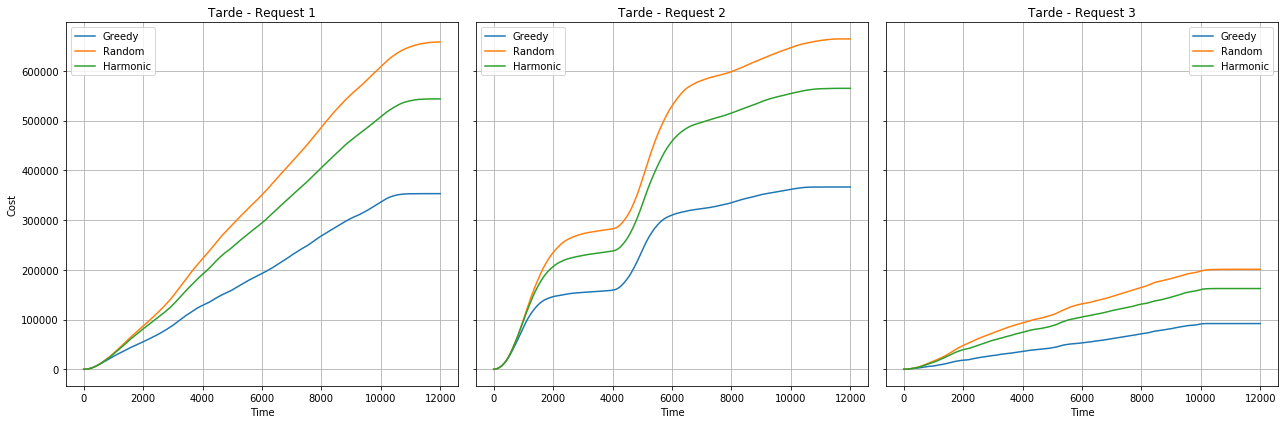

In [746]:
plotCosts(gree[3:6], rand[3:6], harm[3:6], title="Tarde")

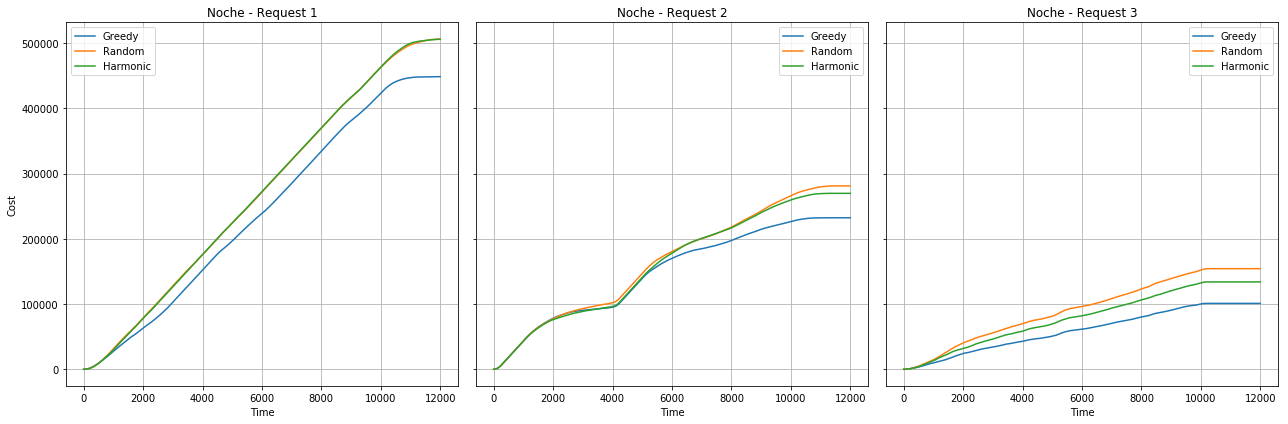

In [747]:
plotCosts(gree[6:], rand[6:], harm[6:], title="Noche")